# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

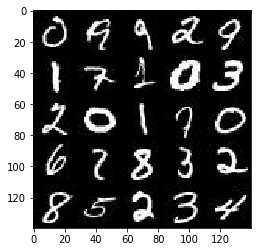

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

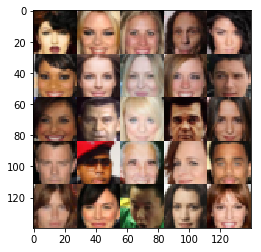

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    image_placeholder = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_image')
    z_placeholder = tf.placeholder(tf.float32, (None, z_dim), name='z')
    learning_rate_placeholder = tf.placeholder(tf.float32, name='learning_rate')

    return image_placeholder, z_placeholder, learning_rate_placeholder


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:

ALPHA = 0.01
def leaky_relu(logits):
    return tf.maximum(ALPHA * logits, logits)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #  28 * 28 * 3
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = leaky_relu(x1)
        # 14 * 14 * 64
        
        x2 = tf.layers.conv2d(x1, 128, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = leaky_relu(x2)
        # 7 * 7 * 128
        
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = leaky_relu(x3)
        # 4 * 4 * 256
        
        flattened = tf.reshape(x3, (-1, 4*4*128))
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
        
    return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
# https://arxiv.org/pdf/1511.06434.pdf with some modifications
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        flat = tf.layers.dense(z, 4 * 4 * 512)
        x1 = tf.reshape(flat, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 4 * 4 * 512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 8 * 8 * 256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 16 * 16 * 128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.slice(logits, [0, 2, 2, 0], [-1, 28, 28, -1])
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
SMOOTH = 0.1
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    fake_images = generator(input_z, out_channel_dim)
    d_logits_fake, _ = discriminator(fake_images)
    d_logits_real, _ = discriminator(input_real, reuse=True)
    
    
    d_cross_entropy_fake = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake,
        labels=tf.zeros_like(d_logits_fake)
    )
    d_loss_fake = tf.reduce_mean(d_cross_entropy_fake)
    
    d_cross_entropy_real = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real,
        labels=tf.ones_like(d_logits_real) * (1 - SMOOTH)
    )
    d_loss_real = tf.reduce_mean(d_cross_entropy_real)
    
    g_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake,
        labels=tf.ones_like(d_logits_fake)
    )
    g_loss = tf.reduce_mean(g_cross_entropy)
    d_loss = d_loss_fake + d_loss_real
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    
    #  tf.control_dependencies block ensures that 
    #  moving averages for batch normalization are updated
    #  http://ruishu.io/2016/12/27/batchnorm/
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        
        d_train_ops = tf.train.AdamOptimizer(
            learning_rate, 
            beta1=beta1
        ).minimize(d_loss, var_list=d_vars)


        g_train_ops = tf.train.AdamOptimizer(
            learning_rate, 
            beta1=beta1
        ).minimize(g_loss, var_list=g_vars)
    
    return d_train_ops, g_train_ops

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, height, width, depth = data_shape
    images, z, learn_rate = model_inputs(width, height, depth, z_dim)
    d_loss, g_loss = model_loss(images, z, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for index, batch_images in enumerate(get_batches(batch_size)):
                
                random_vector = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images_rescaled = 2 * batch_images
                
                sess.run(d_opt, feed_dict={
                    images: batch_images_rescaled,
                    z: random_vector,
                    learn_rate: learning_rate
                })
                
                sess.run(g_opt, feed_dict={
                    images: batch_images_rescaled,
                    z: random_vector,
                    learn_rate: learning_rate
                })
                
                if index % 10 == 0:
                    d_loss_value = d_loss.eval({
                        images: batch_images_rescaled,
                        z: random_vector
                    })
                    
                    g_loss_value = g_loss.eval({
                        z: random_vector
                    })
                    print("generator error: %f, discriminator error: %f" % (g_loss_value, d_loss_value))
                    
                if index % 100 == 0:
                    show_generator_output(sess, 25, z, depth, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

generator error: 0.283856, discriminator error: 4.827742


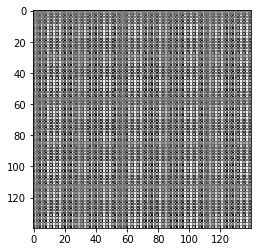

generator error: 5.358346, discriminator error: 0.395167
generator error: 2.433303, discriminator error: 0.498028
generator error: 1.852323, discriminator error: 1.007574
generator error: 0.722758, discriminator error: 1.446485
generator error: 2.316794, discriminator error: 0.781547
generator error: 2.819132, discriminator error: 0.874399
generator error: 1.051934, discriminator error: 1.026978
generator error: 1.409500, discriminator error: 0.877084
generator error: 2.124323, discriminator error: 0.564126
generator error: 0.934194, discriminator error: 1.313973


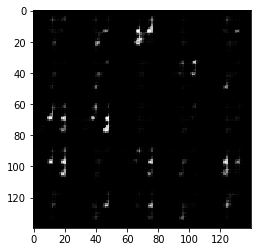

generator error: 2.597544, discriminator error: 1.459301
generator error: 0.771813, discriminator error: 1.292120
generator error: 2.693934, discriminator error: 1.354143
generator error: 1.031933, discriminator error: 1.040995
generator error: 1.765054, discriminator error: 0.949543
generator error: 1.842408, discriminator error: 0.701866
generator error: 0.911372, discriminator error: 0.999306
generator error: 2.265543, discriminator error: 0.884680
generator error: 1.178962, discriminator error: 0.970253
generator error: 0.793956, discriminator error: 1.196064


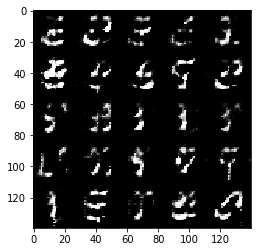

generator error: 1.819474, discriminator error: 1.271784
generator error: 1.119309, discriminator error: 1.049511
generator error: 1.305121, discriminator error: 0.804802
generator error: 1.245727, discriminator error: 0.919981
generator error: 0.575685, discriminator error: 1.632929
generator error: 0.789807, discriminator error: 1.213443
generator error: 0.905245, discriminator error: 1.377745
generator error: 1.043172, discriminator error: 1.079135
generator error: 1.214892, discriminator error: 1.108403
generator error: 1.280405, discriminator error: 1.205860


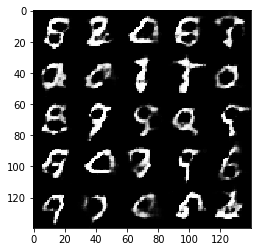

generator error: 0.823256, discriminator error: 1.147413
generator error: 1.343490, discriminator error: 1.157943
generator error: 0.977593, discriminator error: 1.134596
generator error: 0.749021, discriminator error: 1.256399
generator error: 1.197702, discriminator error: 1.234770
generator error: 0.633372, discriminator error: 1.250256
generator error: 1.718171, discriminator error: 1.262272
generator error: 0.946024, discriminator error: 1.180869
generator error: 0.792747, discriminator error: 1.209331
generator error: 1.184069, discriminator error: 1.041813


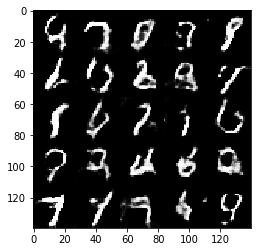

generator error: 0.986787, discriminator error: 1.188751
generator error: 1.547480, discriminator error: 1.193132
generator error: 1.367448, discriminator error: 1.066370
generator error: 0.963511, discriminator error: 1.081435
generator error: 1.249027, discriminator error: 1.237623
generator error: 1.178752, discriminator error: 1.083415
generator error: 1.168091, discriminator error: 1.036911
generator error: 1.076893, discriminator error: 1.033783
generator error: 0.570534, discriminator error: 1.422149
generator error: 1.118299, discriminator error: 1.275501


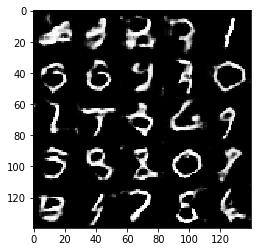

generator error: 0.957374, discriminator error: 1.248411
generator error: 0.417959, discriminator error: 1.544032
generator error: 1.530320, discriminator error: 1.270177
generator error: 0.680340, discriminator error: 1.356261
generator error: 0.642677, discriminator error: 1.330099
generator error: 1.635489, discriminator error: 1.261558
generator error: 0.583901, discriminator error: 1.385631
generator error: 1.046755, discriminator error: 1.245940
generator error: 1.324677, discriminator error: 1.122414
generator error: 1.033568, discriminator error: 1.198058


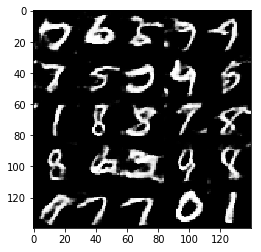

generator error: 1.577335, discriminator error: 1.310994
generator error: 1.262944, discriminator error: 1.061872
generator error: 1.133050, discriminator error: 1.019050
generator error: 1.255423, discriminator error: 1.150543
generator error: 0.894581, discriminator error: 1.290049
generator error: 0.751319, discriminator error: 1.403631
generator error: 0.402661, discriminator error: 1.624608
generator error: 0.889563, discriminator error: 1.281068
generator error: 1.180514, discriminator error: 1.249921
generator error: 1.243332, discriminator error: 1.187730


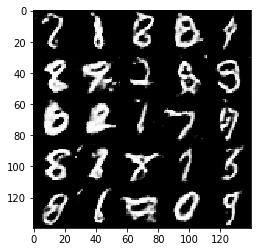

generator error: 0.922102, discriminator error: 1.192021
generator error: 0.720592, discriminator error: 1.293190
generator error: 0.893146, discriminator error: 1.118325
generator error: 1.370731, discriminator error: 1.210419
generator error: 1.374343, discriminator error: 1.187786
generator error: 0.822962, discriminator error: 1.239520
generator error: 1.469836, discriminator error: 1.286999
generator error: 2.340417, discriminator error: 1.321200
generator error: 1.147045, discriminator error: 1.236750
generator error: 1.057390, discriminator error: 1.118380


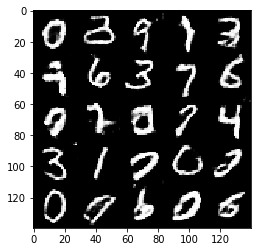

generator error: 0.475405, discriminator error: 1.473326
generator error: 1.428588, discriminator error: 1.264407
generator error: 0.828497, discriminator error: 1.264505
generator error: 1.157822, discriminator error: 1.252053
generator error: 1.445974, discriminator error: 1.151178
generator error: 1.760654, discriminator error: 1.220224
generator error: 0.895710, discriminator error: 1.197330
generator error: 0.645371, discriminator error: 1.307045
generator error: 1.123983, discriminator error: 1.151783
generator error: 1.029279, discriminator error: 1.180654


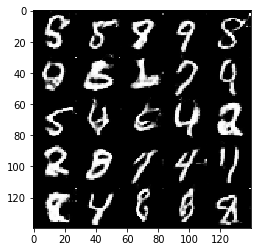

generator error: 1.040063, discriminator error: 1.208337
generator error: 1.093747, discriminator error: 1.247810
generator error: 0.502956, discriminator error: 1.480566
generator error: 0.776457, discriminator error: 1.269822


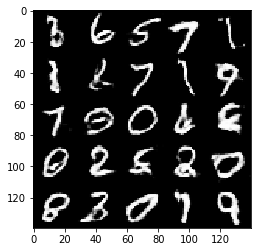

generator error: 1.605156, discriminator error: 1.405552
generator error: 0.654875, discriminator error: 1.288197
generator error: 1.066909, discriminator error: 1.188509
generator error: 1.073928, discriminator error: 1.164077
generator error: 0.797097, discriminator error: 1.301601
generator error: 0.778368, discriminator error: 1.229205
generator error: 0.970320, discriminator error: 1.104391
generator error: 1.533186, discriminator error: 1.067930
generator error: 0.276800, discriminator error: 2.007859
generator error: 0.750843, discriminator error: 1.313555


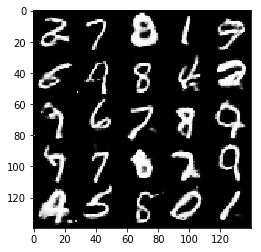

generator error: 0.652232, discriminator error: 1.237393
generator error: 1.929791, discriminator error: 1.081071
generator error: 0.772817, discriminator error: 1.304412
generator error: 0.744154, discriminator error: 1.231829
generator error: 0.580028, discriminator error: 1.349778
generator error: 0.619330, discriminator error: 1.363304
generator error: 0.361199, discriminator error: 1.702543
generator error: 0.924877, discriminator error: 1.244686
generator error: 0.479640, discriminator error: 1.463763
generator error: 2.252424, discriminator error: 1.498857


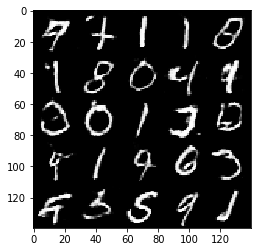

generator error: 0.899984, discriminator error: 1.250619
generator error: 0.720754, discriminator error: 1.321801
generator error: 0.820144, discriminator error: 1.154258
generator error: 0.612771, discriminator error: 1.422951
generator error: 0.608283, discriminator error: 1.311707
generator error: 1.228429, discriminator error: 1.363129
generator error: 0.228789, discriminator error: 2.159452
generator error: 0.693488, discriminator error: 1.291605
generator error: 0.665024, discriminator error: 1.351147
generator error: 0.748362, discriminator error: 1.253439


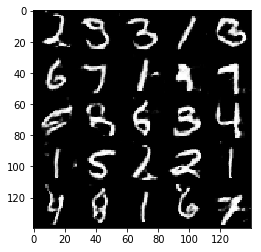

generator error: 1.150964, discriminator error: 1.141170
generator error: 0.638066, discriminator error: 1.273432
generator error: 1.024543, discriminator error: 1.034142
generator error: 0.674437, discriminator error: 1.253264
generator error: 0.668290, discriminator error: 1.245137
generator error: 1.104624, discriminator error: 1.064728
generator error: 0.894802, discriminator error: 1.125934
generator error: 2.298245, discriminator error: 1.673707
generator error: 0.867953, discriminator error: 1.226432
generator error: 0.489486, discriminator error: 1.412212


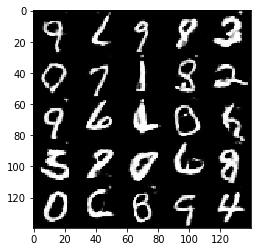

generator error: 0.625982, discriminator error: 1.305429
generator error: 1.067457, discriminator error: 1.219510
generator error: 0.894805, discriminator error: 1.162308
generator error: 0.748210, discriminator error: 1.240979
generator error: 1.325886, discriminator error: 1.110183
generator error: 0.863164, discriminator error: 1.149209
generator error: 1.332884, discriminator error: 0.979693
generator error: 0.897419, discriminator error: 1.186175
generator error: 0.949072, discriminator error: 1.118883
generator error: 1.026558, discriminator error: 1.119462


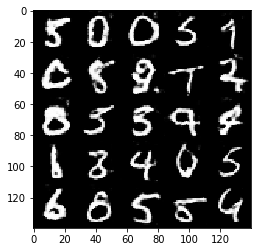

generator error: 0.632725, discriminator error: 1.303161
generator error: 0.678959, discriminator error: 1.322864
generator error: 0.560114, discriminator error: 1.353251
generator error: 1.083056, discriminator error: 1.120600
generator error: 0.663583, discriminator error: 1.327188
generator error: 2.002403, discriminator error: 1.338429
generator error: 0.646396, discriminator error: 1.274409
generator error: 0.361371, discriminator error: 1.705642
generator error: 0.509324, discriminator error: 1.418683
generator error: 1.952888, discriminator error: 1.560356


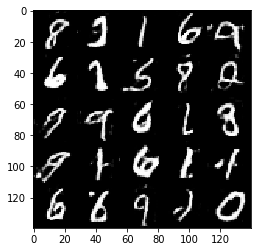

generator error: 0.627266, discriminator error: 1.421057
generator error: 0.874321, discriminator error: 1.227049
generator error: 0.385000, discriminator error: 1.700161
generator error: 0.538529, discriminator error: 1.376722
generator error: 0.656711, discriminator error: 1.208256
generator error: 0.566542, discriminator error: 1.365274
generator error: 1.287402, discriminator error: 1.047112
generator error: 0.187916, discriminator error: 2.307753
generator error: 0.640688, discriminator error: 1.316454
generator error: 0.794047, discriminator error: 1.087740


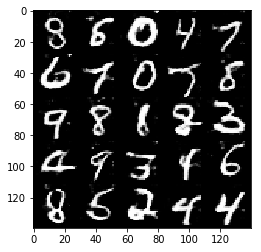

generator error: 1.169254, discriminator error: 1.111645
generator error: 0.479052, discriminator error: 1.554709
generator error: 1.197044, discriminator error: 0.971695
generator error: 0.903569, discriminator error: 1.059797
generator error: 0.698741, discriminator error: 1.245770
generator error: 0.261485, discriminator error: 2.010909
generator error: 1.361336, discriminator error: 0.903031
generator error: 1.094202, discriminator error: 1.044380
generator error: 1.114607, discriminator error: 1.287352
generator error: 1.349572, discriminator error: 0.888541


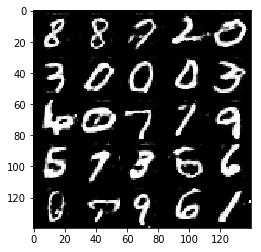

generator error: 2.912251, discriminator error: 1.016968
generator error: 1.302812, discriminator error: 1.009037
generator error: 0.852373, discriminator error: 1.048774
generator error: 0.399964, discriminator error: 1.627034
generator error: 0.819190, discriminator error: 1.172211
generator error: 1.381732, discriminator error: 0.900734
generator error: 1.159669, discriminator error: 0.998409
generator error: 0.904356, discriminator error: 0.948771
generator error: 1.484692, discriminator error: 0.934445
generator error: 0.901012, discriminator error: 1.097921


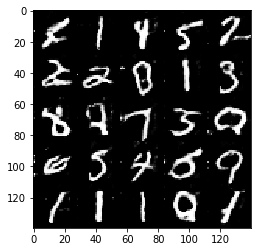

generator error: 0.969659, discriminator error: 1.058752
generator error: 1.086325, discriminator error: 1.068185
generator error: 0.779199, discriminator error: 1.180749


In [12]:
batch_size = 64
z_dim = 32
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

generator error: 0.039142, discriminator error: 3.892176


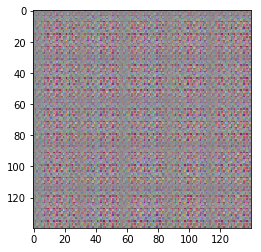

generator error: 1.812598, discriminator error: 0.644341
generator error: 2.176386, discriminator error: 0.503979
generator error: 3.456744, discriminator error: 0.418384
generator error: 2.424325, discriminator error: 0.479247
generator error: 2.889868, discriminator error: 0.430819
generator error: 6.631680, discriminator error: 1.294524
generator error: 2.591802, discriminator error: 1.276065
generator error: 0.621494, discriminator error: 1.438785
generator error: 2.644021, discriminator error: 1.236977
generator error: 1.858157, discriminator error: 0.939332


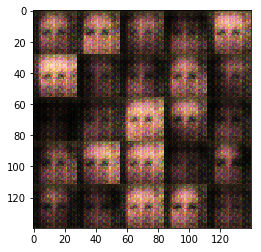

generator error: 2.500141, discriminator error: 1.162908
generator error: 2.268198, discriminator error: 1.027245
generator error: 0.754677, discriminator error: 1.182353
generator error: 0.963041, discriminator error: 1.124276
generator error: 0.478843, discriminator error: 1.660040
generator error: 1.137298, discriminator error: 1.390117
generator error: 0.841739, discriminator error: 1.222256
generator error: 0.794284, discriminator error: 1.219207
generator error: 0.716307, discriminator error: 1.416739
generator error: 0.607359, discriminator error: 1.489811


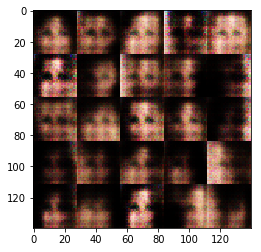

generator error: 1.244483, discriminator error: 1.034817
generator error: 0.901088, discriminator error: 1.277539
generator error: 1.007049, discriminator error: 1.395043
generator error: 1.204446, discriminator error: 1.096204
generator error: 0.963899, discriminator error: 1.108091
generator error: 1.000340, discriminator error: 1.446072
generator error: 1.545966, discriminator error: 1.180880
generator error: 1.114250, discriminator error: 1.203055
generator error: 1.513851, discriminator error: 0.883979
generator error: 1.250688, discriminator error: 0.939554


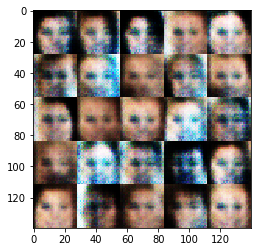

generator error: 0.375916, discriminator error: 1.712032
generator error: 0.782540, discriminator error: 1.349593
generator error: 2.094198, discriminator error: 0.907103
generator error: 0.682061, discriminator error: 1.368559
generator error: 2.878658, discriminator error: 1.384084
generator error: 0.820907, discriminator error: 1.178827
generator error: 1.372689, discriminator error: 0.826618
generator error: 2.867309, discriminator error: 1.128312
generator error: 0.390850, discriminator error: 1.669792
generator error: 2.225172, discriminator error: 0.624340


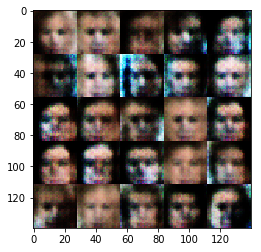

generator error: 1.531939, discriminator error: 0.908007
generator error: 2.310756, discriminator error: 1.540655
generator error: 1.851780, discriminator error: 1.072696
generator error: 1.417244, discriminator error: 0.843972
generator error: 1.532189, discriminator error: 0.780049
generator error: 1.096118, discriminator error: 1.191915
generator error: 1.159628, discriminator error: 0.905555
generator error: 0.812129, discriminator error: 1.371252
generator error: 0.943606, discriminator error: 1.029797
generator error: 0.869406, discriminator error: 1.136607


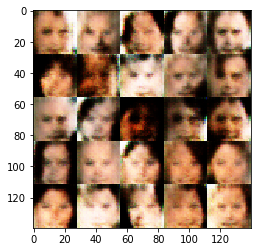

generator error: 0.890418, discriminator error: 1.304296
generator error: 1.495351, discriminator error: 0.724751
generator error: 0.643957, discriminator error: 1.237576
generator error: 0.872159, discriminator error: 1.702784
generator error: 0.654654, discriminator error: 1.397877
generator error: 1.017371, discriminator error: 1.241997
generator error: 0.941523, discriminator error: 1.131534
generator error: 1.638230, discriminator error: 1.289415
generator error: 1.492065, discriminator error: 0.976982
generator error: 0.906762, discriminator error: 1.188179


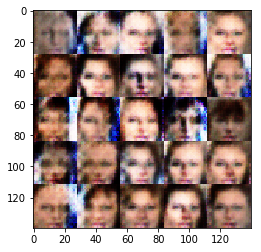

generator error: 1.305391, discriminator error: 0.786845
generator error: 1.108668, discriminator error: 1.022346
generator error: 1.892241, discriminator error: 1.171491
generator error: 1.366560, discriminator error: 0.778471
generator error: 0.899377, discriminator error: 1.197647
generator error: 2.022086, discriminator error: 1.916467
generator error: 1.284285, discriminator error: 1.115581
generator error: 0.887097, discriminator error: 1.369732
generator error: 0.549300, discriminator error: 1.489889
generator error: 0.591955, discriminator error: 1.440471


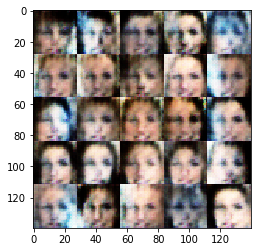

generator error: 1.429716, discriminator error: 1.043323
generator error: 0.999075, discriminator error: 1.023174
generator error: 0.515492, discriminator error: 1.407691
generator error: 2.538035, discriminator error: 2.092817
generator error: 0.941656, discriminator error: 1.203667
generator error: 0.600991, discriminator error: 1.395655
generator error: 1.241529, discriminator error: 1.094309
generator error: 0.940267, discriminator error: 1.063620
generator error: 1.067185, discriminator error: 1.110927
generator error: 1.032374, discriminator error: 1.351458


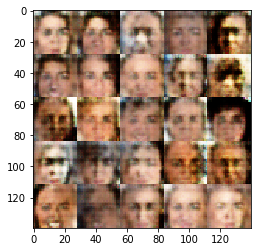

generator error: 1.214597, discriminator error: 1.021564
generator error: 1.504743, discriminator error: 1.665284
generator error: 0.930070, discriminator error: 1.136747
generator error: 1.036162, discriminator error: 1.130379
generator error: 0.500694, discriminator error: 1.454060
generator error: 1.416047, discriminator error: 1.244364
generator error: 1.185063, discriminator error: 1.298126
generator error: 0.491154, discriminator error: 1.467946
generator error: 1.375785, discriminator error: 1.300908
generator error: 1.353701, discriminator error: 0.756899


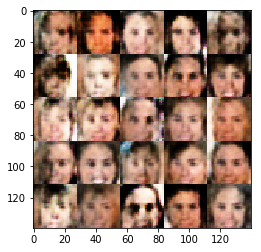

generator error: 0.867199, discriminator error: 1.199855
generator error: 1.253891, discriminator error: 0.830990
generator error: 0.948958, discriminator error: 1.119184
generator error: 0.812888, discriminator error: 1.139947
generator error: 0.923836, discriminator error: 1.169619
generator error: 1.070880, discriminator error: 1.149606
generator error: 1.235565, discriminator error: 0.949877
generator error: 1.509216, discriminator error: 0.885597
generator error: 1.293421, discriminator error: 0.949805
generator error: 0.777836, discriminator error: 1.191706


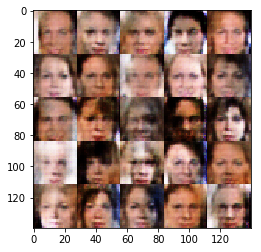

generator error: 1.745139, discriminator error: 1.482612
generator error: 1.126321, discriminator error: 1.196755
generator error: 2.055593, discriminator error: 1.353141
generator error: 0.723407, discriminator error: 1.113586
generator error: 1.424624, discriminator error: 0.907148
generator error: 0.844218, discriminator error: 1.155221
generator error: 0.614376, discriminator error: 1.287520
generator error: 3.042607, discriminator error: 0.810392
generator error: 1.089225, discriminator error: 1.047104
generator error: 0.930624, discriminator error: 1.119699


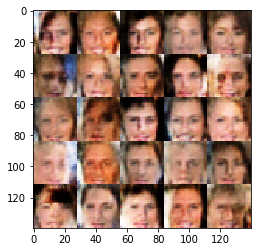

generator error: 1.868221, discriminator error: 0.690914
generator error: 0.757090, discriminator error: 1.188303
generator error: 0.643984, discriminator error: 1.315638
generator error: 0.980006, discriminator error: 1.315010
generator error: 1.167732, discriminator error: 1.246671
generator error: 1.034545, discriminator error: 1.063937
generator error: 1.117233, discriminator error: 1.167518
generator error: 0.686341, discriminator error: 1.256436
generator error: 0.375181, discriminator error: 1.666952
generator error: 1.092091, discriminator error: 1.070873


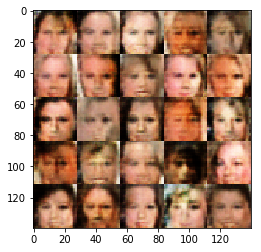

generator error: 1.258875, discriminator error: 1.059926
generator error: 2.809487, discriminator error: 2.434044
generator error: 0.868089, discriminator error: 1.241132
generator error: 0.719547, discriminator error: 1.428551
generator error: 0.772941, discriminator error: 1.372665
generator error: 0.962419, discriminator error: 1.135379
generator error: 1.598482, discriminator error: 0.898800
generator error: 0.896793, discriminator error: 1.197914
generator error: 2.284938, discriminator error: 1.811377
generator error: 1.453522, discriminator error: 0.832666


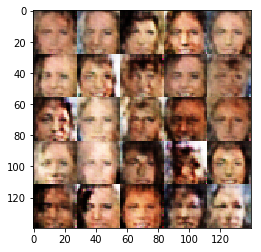

generator error: 0.994126, discriminator error: 1.120571
generator error: 1.149411, discriminator error: 0.996567
generator error: 1.119202, discriminator error: 1.003603
generator error: 0.574960, discriminator error: 1.420861
generator error: 0.268764, discriminator error: 1.920936
generator error: 0.873740, discriminator error: 1.235809
generator error: 0.661250, discriminator error: 1.435361
generator error: 1.061866, discriminator error: 1.136427
generator error: 0.796263, discriminator error: 1.096473
generator error: 0.512126, discriminator error: 1.382096


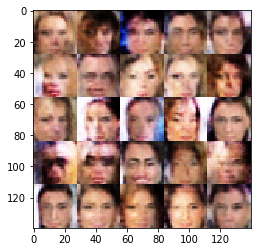

generator error: 1.158322, discriminator error: 1.135686
generator error: 1.000991, discriminator error: 0.961234
generator error: 1.101767, discriminator error: 1.102680
generator error: 1.181928, discriminator error: 0.862650
generator error: 0.851359, discriminator error: 1.159129
generator error: 1.115636, discriminator error: 1.077425
generator error: 1.772929, discriminator error: 0.697628
generator error: 0.683060, discriminator error: 1.322631
generator error: 0.638234, discriminator error: 1.300730
generator error: 0.579140, discriminator error: 1.397658


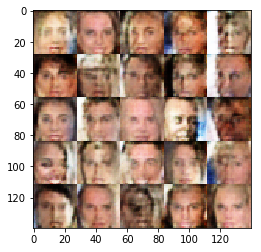

generator error: 0.795133, discriminator error: 1.154961
generator error: 1.023065, discriminator error: 1.009616
generator error: 0.866801, discriminator error: 1.156531
generator error: 0.781462, discriminator error: 1.215276
generator error: 2.129890, discriminator error: 0.650014
generator error: 0.860514, discriminator error: 1.248980
generator error: 1.020479, discriminator error: 1.177424
generator error: 0.979849, discriminator error: 1.096650
generator error: 1.317049, discriminator error: 0.890480
generator error: 0.488871, discriminator error: 1.472523


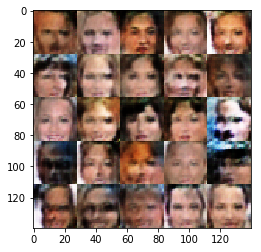

generator error: 1.507076, discriminator error: 0.945405
generator error: 1.129903, discriminator error: 1.180030
generator error: 1.242774, discriminator error: 1.049197
generator error: 1.461981, discriminator error: 0.904233
generator error: 1.326867, discriminator error: 0.911223
generator error: 0.624389, discriminator error: 1.289304
generator error: 0.451384, discriminator error: 1.515409
generator error: 0.831501, discriminator error: 1.187442
generator error: 1.059017, discriminator error: 1.121983
generator error: 1.649448, discriminator error: 0.968621


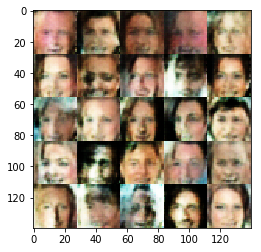

generator error: 0.717801, discriminator error: 1.426129
generator error: 0.898841, discriminator error: 1.092196
generator error: 0.829174, discriminator error: 1.171315
generator error: 1.120392, discriminator error: 0.945440
generator error: 0.743438, discriminator error: 1.193359
generator error: 1.932420, discriminator error: 1.174260
generator error: 0.681420, discriminator error: 1.314560
generator error: 0.842439, discriminator error: 1.163421
generator error: 0.328152, discriminator error: 1.799091
generator error: 1.192133, discriminator error: 1.159279


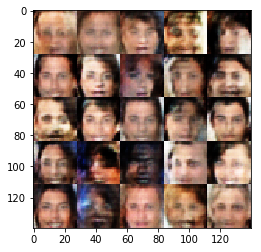

generator error: 0.854917, discriminator error: 1.143444
generator error: 1.583812, discriminator error: 0.753778
generator error: 0.976903, discriminator error: 1.114353
generator error: 1.774678, discriminator error: 1.512959
generator error: 0.810314, discriminator error: 1.294690
generator error: 1.166390, discriminator error: 1.508973
generator error: 1.132619, discriminator error: 0.959747
generator error: 0.917792, discriminator error: 1.069584
generator error: 0.690498, discriminator error: 1.235339
generator error: 1.987877, discriminator error: 1.171040


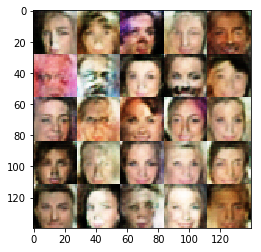

generator error: 0.713992, discriminator error: 1.190492
generator error: 0.434871, discriminator error: 1.564637
generator error: 1.035345, discriminator error: 1.297656
generator error: 1.535423, discriminator error: 1.124210
generator error: 0.510471, discriminator error: 1.447336
generator error: 0.493641, discriminator error: 1.505771
generator error: 0.942094, discriminator error: 1.060352
generator error: 0.843241, discriminator error: 1.151895
generator error: 0.799029, discriminator error: 1.197672
generator error: 1.609098, discriminator error: 0.907722


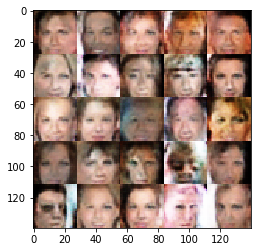

generator error: 0.710623, discriminator error: 1.257310
generator error: 1.033260, discriminator error: 1.211745
generator error: 2.445309, discriminator error: 0.795619
generator error: 0.815475, discriminator error: 1.264140
generator error: 0.562673, discriminator error: 1.333740
generator error: 0.887107, discriminator error: 1.107027
generator error: 1.012913, discriminator error: 1.301519
generator error: 0.768860, discriminator error: 1.398331
generator error: 0.812484, discriminator error: 1.218709
generator error: 1.059313, discriminator error: 1.053124


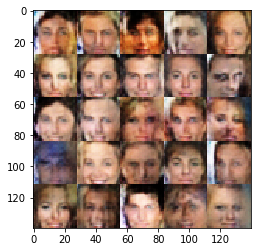

generator error: 0.800016, discriminator error: 1.283426
generator error: 1.089050, discriminator error: 1.126226
generator error: 0.666833, discriminator error: 1.230202
generator error: 1.193038, discriminator error: 1.228033
generator error: 0.977882, discriminator error: 1.233736
generator error: 0.928652, discriminator error: 1.085115
generator error: 0.809389, discriminator error: 1.226829
generator error: 1.701456, discriminator error: 0.732427
generator error: 0.262845, discriminator error: 1.935258
generator error: 0.755429, discriminator error: 1.280447


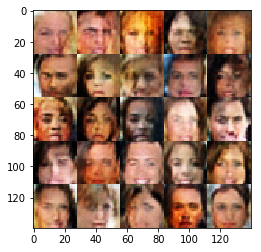

generator error: 0.750048, discriminator error: 1.381996
generator error: 0.637651, discriminator error: 1.317043
generator error: 1.193402, discriminator error: 0.961505
generator error: 0.913572, discriminator error: 1.279362
generator error: 1.847425, discriminator error: 0.712378
generator error: 0.969045, discriminator error: 1.340392
generator error: 1.205506, discriminator error: 0.887566
generator error: 0.809141, discriminator error: 1.138086
generator error: 0.861454, discriminator error: 1.156454
generator error: 1.643205, discriminator error: 0.761256


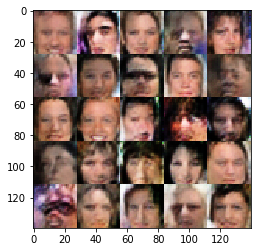

generator error: 1.045229, discriminator error: 1.161953
generator error: 0.876031, discriminator error: 1.286607
generator error: 0.839931, discriminator error: 1.220248
generator error: 1.086634, discriminator error: 1.112966
generator error: 1.081422, discriminator error: 0.937332
generator error: 0.788897, discriminator error: 1.089969
generator error: 0.228946, discriminator error: 2.068182
generator error: 0.343410, discriminator error: 1.832025
generator error: 0.632074, discriminator error: 1.453447
generator error: 0.889610, discriminator error: 1.307869


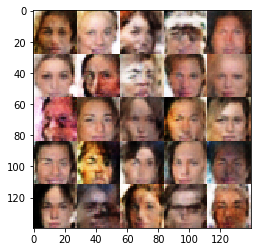

generator error: 0.888470, discriminator error: 1.174375
generator error: 0.827621, discriminator error: 1.127768
generator error: 1.060736, discriminator error: 0.957069
generator error: 1.680013, discriminator error: 0.882595
generator error: 1.343482, discriminator error: 1.392048
generator error: 1.030668, discriminator error: 1.283781
generator error: 1.047177, discriminator error: 1.222807
generator error: 1.030763, discriminator error: 1.185266
generator error: 0.632104, discriminator error: 1.434047
generator error: 0.570529, discriminator error: 1.360684


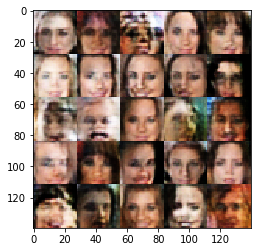

generator error: 0.964034, discriminator error: 1.230536
generator error: 0.944335, discriminator error: 1.122047
generator error: 0.773530, discriminator error: 1.238400
generator error: 1.008133, discriminator error: 1.143364
generator error: 1.105764, discriminator error: 1.118858
generator error: 0.901625, discriminator error: 1.091236
generator error: 0.913869, discriminator error: 1.306374
generator error: 1.277220, discriminator error: 1.203424
generator error: 0.986362, discriminator error: 1.182684
generator error: 0.777758, discriminator error: 1.237852


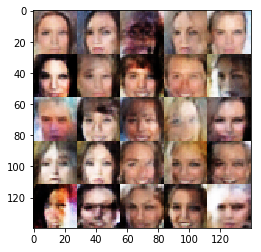

generator error: 2.116974, discriminator error: 1.443564
generator error: 0.787311, discriminator error: 1.424385
generator error: 0.934275, discriminator error: 1.167493
generator error: 0.821169, discriminator error: 1.363988
generator error: 0.661927, discriminator error: 1.373559
generator error: 0.820092, discriminator error: 1.274102
generator error: 0.832607, discriminator error: 1.199409
generator error: 0.644573, discriminator error: 1.428816
generator error: 1.177316, discriminator error: 1.109845
generator error: 0.933625, discriminator error: 1.191881


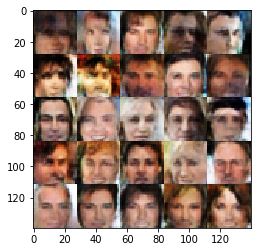

generator error: 0.806089, discriminator error: 1.241700
generator error: 0.676870, discriminator error: 1.317026
generator error: 0.966166, discriminator error: 1.179517
generator error: 0.898322, discriminator error: 1.295047
generator error: 0.738115, discriminator error: 1.211943
generator error: 1.202353, discriminator error: 1.111134
generator error: 0.747665, discriminator error: 1.282665
generator error: 0.997717, discriminator error: 1.261156
generator error: 1.578823, discriminator error: 1.618763
generator error: 0.744614, discriminator error: 1.314472


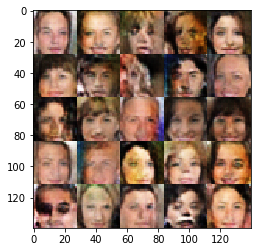

generator error: 0.661848, discriminator error: 1.364140
generator error: 0.889123, discriminator error: 1.181210
generator error: 0.915734, discriminator error: 1.115423
generator error: 0.743046, discriminator error: 1.248462
generator error: 0.723318, discriminator error: 1.392530
generator error: 0.873588, discriminator error: 1.063032
generator error: 0.640171, discriminator error: 1.237050
generator error: 0.395336, discriminator error: 1.623669
generator error: 0.752807, discriminator error: 1.330732
generator error: 0.736459, discriminator error: 1.319356


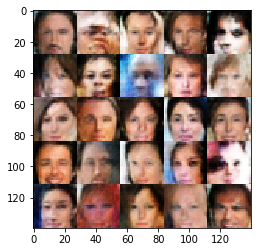

generator error: 0.675201, discriminator error: 1.328443
generator error: 0.955874, discriminator error: 1.176652
generator error: 0.623870, discriminator error: 1.300926
generator error: 0.650941, discriminator error: 1.347046
generator error: 0.969666, discriminator error: 1.034189
generator error: 0.696372, discriminator error: 1.297984
generator error: 0.510010, discriminator error: 1.403855
generator error: 0.853595, discriminator error: 1.200415
generator error: 0.771889, discriminator error: 1.324878
generator error: 1.372619, discriminator error: 1.131598


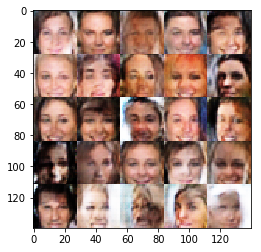

generator error: 0.857288, discriminator error: 1.216341
generator error: 0.605197, discriminator error: 1.472039
generator error: 0.760058, discriminator error: 1.167107
generator error: 0.468761, discriminator error: 1.514657
generator error: 0.542353, discriminator error: 1.373839
generator error: 0.601828, discriminator error: 1.353252
generator error: 0.801387, discriminator error: 1.249375
generator error: 0.618822, discriminator error: 1.553116
generator error: 0.760940, discriminator error: 1.382069
generator error: 0.860956, discriminator error: 1.177766


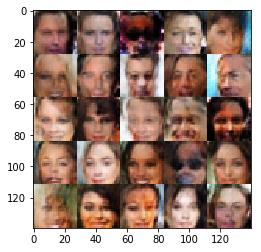

generator error: 2.082793, discriminator error: 0.941870
generator error: 0.886886, discriminator error: 1.324970
generator error: 0.927262, discriminator error: 1.181994
generator error: 1.306165, discriminator error: 0.819866
generator error: 0.588463, discriminator error: 1.370527
generator error: 0.667943, discriminator error: 1.462273


In [13]:
batch_size = 64
z_dim = 256
learning_rate = 0.0005
beta1 = 0.5
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.